In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rbo
from scipy import stats

import os

In [2]:
def different_seed_compare(seed1, iter, dimen, df):
    dimen_generator_re = dimen
    iteration = iter
    # seed_pair = seed_pair_2
    iterated_seed = []
    for i in range(iteration):
        print(i)
        if i == 0:
            seed_pair = seed1
        else:
            seed_pair = generated_seed
        # dimension_seed2_dim2 = dimen_generator_dim50.generate_dimenations_after_iteration([seed_pair], 'dot')
        generated_seed = dimen_generator_re.generate_dimenations_after_iteration([seed_pair], 'cos')
        iterated_seed.append(list(generated_seed))

    if iteration == 0:
        iterated_seed.append(seed1)
    seed_final = iterated_seed[-1]
    # seed_final = seed_pair_2
    final_dimen = dimen_generator_re.from_nearest_neighbour([seed_final])
    # print('final dim:', final_dimen)

    scores, ranks, pairs = generate_score_ranking(df, [final_dimen])
    # ranks = transform_df_re(ranks)
    print('iterated_seed',iterated_seed)

    return scores, ranks, pairs

def transform_df_re(tar_df):
    re_df = pd.DataFrame(columns=tar_df.columns)
    re_df['partisan'] = -tar_df['partisan']
    rank1 = re_df['partisan'].rank()
    re_df['rank'] = rank1
    return pd.DataFrame(re_df['rank'])

def func_stas_compare(r1, r2):
    tau, p = stats.kendalltau(r1, r2)
    print('tau:', tau)
    spearman = stats.spearmanr(r1, r2)
    print('spearman:', spearman)
    rboo = rbo.RankingSimilarity(np.array(r1), np.array(r2)).rbo()
    print('rbo:', rboo)
    return tau, spearman, rboo

In [3]:
def embedding_preprocess(vectors):
    """
    normalise the embedding vectors
    :param vectors: the 318 elite vectors from word2vec
    :return: the normalised vectors
    """
    vectors = vectors.divide(np.linalg.norm(vectors.values, axis=1), axis='rows')
    return vectors

def score_embedding(vectors, dimensions):
    """
    turn the vector of elite into scores
    :param vectors: embedding vectors
    :param dimensions: the partisian/any generated dimension
    :return: scores on this dimension
    """
    columns = {}
    print(dimensions)
    for name, data in dimensions:
        columns[name] = np.dot(vectors.values, data["vector"] / np.linalg.norm(data["vector"]))
    print('score embedding done')
    return pd.DataFrame(columns, index=vectors.index)


def cosine_similarity(vectors):
    """
    cosine similarity of all vectors
    :param vectors: embedding vectors
    :return: the cosine similarity between each vector
    """
    # normalize vectors
    vectors = vectors.divide(np.linalg.norm(vectors.values, axis=1), axis='rows')
    # dot
    sims = np.dot(vectors.values, vectors.values.T)

    return sims

def all_directions(vectors):
    re_all_directions = vectors.values - vectors.values.T
    return re_all_directions


def generate_score_ranking(df, re_dimension):
    re_scores_csv = score_embedding(df, zip(['partisan'], re_dimension))

    pairs_list = []
    for name, dimen in zip(['partisan'], re_dimension):
        print("Dimension %s:" % name)
        print("\tSeed: %s" % dimen["seed"])
        print("\tFound seeds:")
        for c1, c2 in zip(dimen["left_comms"], dimen["right_comms"]):
            pairs_list.append([c1, c2])
            print("\t\t%s -> %s" % (c1, c2))

    re_scores_csv.index.name = 'elite'
    re_scores_rank = re_scores_csv.copy()
    re_scores_rank['rank'] = re_scores_rank.rank()


    return re_scores_csv, re_scores_rank, pairs_list


In [4]:
from sklearn.metrics.pairwise import cosine_similarity

class DimenGenerator_iteration:

    def __init__(self, vectors):
        self.vectors = vectors

        self.name_mapping = {name.lower(): name for name in self.vectors.index}
        # self.num_iteration = num_iteration
        comm_names = list(self.vectors.index)
        # 找nn 用cos sim
        cosine_sims = cosine_similarity(self.vectors)

        # Find each community's nearest neighbours
        ranks = cosine_sims.argsort().argsort()

        # Take n NNs
        nn_n = 20
        only_calculate_for = \
            (ranks > (len(comm_names) - nn_n - 2)) & \
            ~np.diag(np.ones(len(comm_names), dtype=bool))

        indices_to_calc = np.nonzero(only_calculate_for)

        self.index = []
        directions = []
        for i in range(0, len(indices_to_calc[0])):
            c1 = indices_to_calc[0][i]
            c2 = indices_to_calc[1][i]

            # append names
            self.index.append((comm_names[c1], comm_names[c2])) # n closest people to every people
            # print(self.index)
            # append directions
            directions.append(self.vectors.iloc[c2] - self.vectors.iloc[c1])
        # print(self.index)


        print("%d valid directions, %d calculated." % (np.sum(only_calculate_for), len(directions)))
        # 这里面有所有318个elite与他的x个nn的vector difference
        self.directions_to_score = pd.DataFrame(index=pd.MultiIndex.from_tuples(self.index), data=directions)

        # self.directions_to_score.to_csv('self_directions.csv')


    def from_nearest_neighbour(self, seeds):
        """
        new way of finding dimensions:
        :param seeds: the chosen seed pair
        :return:
        """
        # get the seed elite1, seed elite 2's vector embedding
        print('start from nearest neighbour')
        left_vector = self.vectors.loc[map(lambda x: x[0], seeds)].values
        right_vector = self.vectors.loc[map(lambda x: x[1], seeds)].values
        seed_diff = right_vector-left_vector


        # get the seed elite1, seed elite 2's n nn's vector difference
        """   """
        left_vals = self.directions_to_score.loc[map(lambda x: x[0], seeds)].values
        right_vals = self.directions_to_score.loc[map(lambda x: x[1], seeds)].values
        # put them in the same narray
        values_leftright = np.vstack((left_vals, right_vals))
        # get the corresponding names for the ad's index
        index_left = [item for item in self.index if item[0] == seeds[0][0]]
        index_right = [item for item in self.index if item[0] == seeds[0][1]]
        index_leftright = index_left + index_right
        # create the df, index is the seed elite and its nn
        self.left_right = pd.DataFrame(index=pd.MultiIndex.from_tuples(index_leftright), data=values_leftright)
        # print('top 20s')
        # print(self.left_right)

        # calculate cos sim between the neighbours' difference between the elites
        cosine_sims_neighbours = cosine_similarity(self.left_right)

        # get the upper right corner of the square matrix, which contain all the cos sim
        rng = int(cosine_sims_neighbours.shape[0]/2)
        real_cosine_sim = cosine_sims_neighbours[:rng, -rng:]

        # chose the top half most similar(maximum value)
        # num_max = int(rng/2)
        num_max = 9
        selected_values = []  # To store the selected values
        used_rows = set()  # To keep track of used rows
        used_cols = set()
        list_rows = []
        list_cols = []
        for _ in range(num_max):
            max_value = -float('inf')
            max_row, max_col = None, None

            for row in range(real_cosine_sim.shape[0]):
                for col in range(real_cosine_sim.shape[1]):
                    if row not in used_rows and col not in used_cols:
                        if real_cosine_sim[row, col] > max_value:
                            max_value = real_cosine_sim[row, col]
                            max_row, max_col = row, col

            selected_values.append(max_value)
            used_rows.add(max_row)
            used_cols.add(max_col)
            list_rows.append(max_row)
            list_cols.append(max_col)

        leftt = [item[1] for item in index_left]
        rightt = [item[1] for item in index_right]
        index_list = []
        vector_list = []

        for item in zip(list_rows, list_cols):
            left_i = item[0]
            right_i = item[1]

            left_name = leftt[left_i]
            right_name = rightt[right_i]
            index_list.append((left_name, right_name))
            v = self.vectors.loc[right_name].values-self.vectors.loc[left_name].values
            vector_list.append(v)
        # directions = pd.concat([pd.DataFrame(seed_directions, index=seeds), directions])
        vector_list.append(seed_diff[0])
        index_list.append(seeds[0])
        direction_group = np.array(vector_list)
        print('direction_group.shape:',direction_group.shape)

        dimension = np.mean(vector_list, axis=0)
            # 添加index
        return {
            "note": "generated from seed pairs",
            "seed": seeds,
            "vector": dimension,
            "argument_directions": direction_group,
            "left_comms": [item[0] for item in index_list],
            "right_comms": [item[1] for item in index_list],
            "pairs": index_list
        }


    def generate_dimensions_from_seeds(self, seeds):
        # return list(map(lambda x: self.generate_dimension_from_seeds([x]), seeds))
        return list(map(lambda x: self.from_nearest_neighbour([x]), seeds))


    def generate_dimenations_after_iteration_2(self, seeds, method):
        print('start iteration part')
        print(seeds[0])
        left_vector = self.vectors.loc[map(lambda x: x[0], seeds)].values
        right_vector = self.vectors.loc[map(lambda x: x[1], seeds)].values
        seed_direction = right_vector-left_vector

        prev_re = self.generate_dimensions_from_seeds(seeds)
        # prev_re = self.from_nearest_neighbour(seeds)

        prev_re_item = prev_re[0] # dictionary inside
        dimen_vector = prev_re_item['vector']
        selected_pairs = prev_re_item['argument_directions']
        ind = prev_re_item['pairs']
        selected_pairs = pd.DataFrame(selected_pairs, index=ind)
        # selected_pairs.loc['seed'] = seed_direction
        selected_pairs.loc['dimen1'] = dimen_vector

        # selected_pairs.iloc[-1] = dimen_vector
        # print(selected_pairs)
        if method == 'cos':
            cos_sim = cosine_similarity(selected_pairs)
            # print('print cos')
            re_sim = cos_sim[-1][:-2] # (9,)

        elif method == 'dot':
            dot_sim = np.dot(selected_pairs.values, selected_pairs.values.T)
            re_sim = dot_sim[-1][:-2]


        print(re_sim)
        ranks = re_sim.argsort()
        # print(re_sim[ranks])
        maxx_index = re_sim.argmax()
        # print(maxx_index)
        new_seed = list(selected_pairs.index)[:-1][maxx_index]
        # print(new_seed)


        return new_seed



    def generate_dimension_from_seeds(self, seeds):

        seed_directions = self.vectors.loc[map(lambda x: x[1], seeds)].values - \
            self.vectors.loc[map(lambda x: x[0], seeds)].values

        seed_similarities = np.dot(self.directions_to_score, seed_directions.T)
        # print(seed_similarities.shape)
        seed_similarities = np.amax(seed_similarities, axis=1)

        directions = self.directions_to_score.iloc[np.flip(seed_similarities.T.argsort())]
        # print('directions')
        # print(directions)


        # How many directions to take?
        num_directions = 10

        # make directions unique subreddits (subreddit can only occur once)
        ban_list = [s for sd in seeds for s in sd]
        i = -1 # to filter out seed pairs
        while (i < len(directions)) and (i < (num_directions + 1)):
            ban_list.extend(directions.index[i])

            l0 = directions.index.get_level_values(0)
            l1 = directions.index.get_level_values(1)
            directions = directions[(np.arange(0, len(directions)) <= i) | ((~l0.isin(ban_list)) & (~l1.isin(ban_list)))]

            i += 1

        # Add seeds to the top
        directions = pd.concat([pd.DataFrame(seed_directions, index=seeds), directions])

        direction_group = directions.iloc[0:num_directions]
        # print(direction_group) # (10*50)

        dimension = np.mean(direction_group.values, axis=0)

        return {
            "note": "generated from seed pairs",
            "seed": seeds,
            "vector": dimension,
            "argument_directions": direction_group,
            "left_comms": list(map(lambda x: x[0], direction_group.index)),
            "right_comms": list(map(lambda x: x[1], direction_group.index)),
            "pairs": list(direction_group.index)
        }
    def generate_dimenations_after_iteration(self, seeds, method):
        print('start iteration part')
        # get all vector differences
        print(seeds[0])
        left_vector = self.vectors.loc[map(lambda x: x[0], seeds)].values
        right_vector = self.vectors.loc[map(lambda x: x[1], seeds)].values
        seed_direction = right_vector-left_vector

        prev_re = self.generate_dimensions_from_seeds(seeds)
        # prev_re = self.from_nearest_neighbour(seeds)

        prev_re_item = prev_re[0] # dictionary inside
        dimen_vector = prev_re_item['vector']

        # selected_pairs = prev_re_item['argument_directions']# first one is the seed vector difference
        vector_diffs, pairs_names = every_difference(self.vectors.values, list_celebrity)
        s1, s2 = vector_diffs.shape[0], vector_diffs.shape[-1]
        reshaped_vector_diffs = vector_diffs.reshape(s1*s1, s2)
        reshaped_pairs_names = pairs_names.reshape(s1*s1, 1)
        print(reshaped_pairs_names)

        diffs_df = pd.DataFrame(reshaped_vector_diffs, index=reshaped_pairs_names)
        diffs_df = diffs_df[~(diffs_df == 0).all(axis=1)]
        new_index = list(diffs_df.index)
        print(new_index[1], type(new_index[1]))
        exclude_index1, exclude_index2 = (seeds[0][0]+ ',' + seeds[0][1],), (seeds[0][1]+ ',' +  seeds[0][0],)
        print(exclude_index1)
        print(exclude_index1 in new_index)
        # ind1, ind2 = np.where(arr == 6)[0][0]
        print(diffs_df.shape)
        diffs_df = diffs_df[(diffs_df.index != exclude_index2)]
        print(diffs_df.shape)
        # diffs_df = pd.concat([pd.DataFrame(dimen_vector, index= 'dimen1'), diffs_df])
        # print(diffs_df.shape)
        dimen_vector = dimen_vector.reshape(-1, diffs_df.shape[-1])

        re_sim = cosine_similarity(diffs_df.values, dimen_vector)

        # print(re_sim)
        ranks = re_sim.argsort()
        # print(re_sim)
        maxx_index = re_sim.argmax()
        # print(maxx_index)
        new_seed = list(diffs_df.index)[maxx_index]
        # print(new_seed, type(new_seed))
        persons = new_seed[0]
        node = persons.find(',')
        person1, person2 = persons[:node], persons[node+1:]
        new_seed = (person1, person2)
        # print(new_seed)


        return new_seed


# # data load, processing

In [5]:

name_df = pd.read_csv('dimen2_embedding.csv', index_col=0)
list_celebrity = list(name_df.index)
re_2 = np.load('dim3.npy', allow_pickle = True)
df_pca_2 = pd.DataFrame(re_2)
df_pca_2['elite'] = list(name_df.index)
df_pca_2 = df_pca_2.set_index('elite')
df_pca_2 = embedding_preprocess(df_pca_2)

"""#####50 dim vectors"""

re_50 = np.load('dim50.npy', allow_pickle = True)
df_pca_50 = pd.DataFrame(re_50)
df_pca_50['elite'] = list(name_df.index)
df_pca_50 = df_pca_50.set_index('elite')
df_pca_50 = embedding_preprocess(df_pca_50)


In [6]:
def every_difference(vectors_matrix, index):
    num_vectors = vectors_matrix.shape[0]
    size = num_vectors
    index_matrix = np.empty((size, size, 1), dtype=object)
    vector_differences = np.zeros((size, size, vectors_matrix.shape[1]))

# Calculate differences between each pair of vectors
    for i in range(size):
        for j in range(i, size):
            p1, p2 = index[i], index[j]
            vector_diff = vectors_matrix[i] - vectors_matrix[j]
            vector_differences[i, j] = vector_diff
            vector_differences[j, i] = -vector_diff
            index_matrix[i,j] = p1+',' +  p2
            index_matrix[j,i] =p2+',' +p1
    return vector_differences, index_matrix

1. iterate to find seed

In [7]:

# seed_pair_2 = ('BarackObama', 'MittRomney')
seed_pair_2 = ('TheDemocrats', 'Senate_GOPs')

In [8]:
# generate variable
dimen_generator_dim2 = DimenGenerator_iteration(df_pca_2)
dimen_generator_dim50 = DimenGenerator_iteration(df_pca_50)


6360 valid directions, 6360 calculated.
6360 valid directions, 6360 calculated.


In [9]:
def different_seed_compare(seed1, iter, dimen, df):
    dimen_generator_re = dimen
    iteration = iter
    # seed_pair = seed_pair_2
    iterated_seed = []
    for i in range(iteration):
        print(i)
        if i == 0:
            seed_pair = seed1
        else:
            seed_pair = generated_seed
        # dimension_seed2_dim2 = dimen_generator_dim50.generate_dimenations_after_iteration([seed_pair], 'dot')
        generated_seed = dimen_generator_re.generate_dimenations_after_iteration([seed_pair], 'cos')
        iterated_seed.append(list(generated_seed))

    if iteration == 0:
        iterated_seed.append(seed1)
    seed_final = iterated_seed[-1]
    # seed_final = seed_pair_2
    final_dimen = dimen_generator_re.from_nearest_neighbour([seed_final])
    # print('final dim:', final_dimen)

    scores, ranks, pairs = generate_score_ranking(df, [final_dimen])
    # ranks = transform_df_re(ranks)
    print('iterated_seed',iterated_seed)

    return scores, ranks, pairs


In [13]:

seed_pair_2 = ('TheDemocrats', 'Senate_GOPs')
seed_pair_3 = ('BarackObama', 'MittRomney')
# seed_pair_ = '(BarackObama, SpeakerBoehner)'
seed_pair_5 = ('nytimes', 'FoxNews')

In [18]:
_, rank_2_10_seed2, pairs_2_10_seed2 = different_seed_compare(seed_pair_2, 0, dimen_generator_dim2, df_pca_2)
_, rank_2_10_seed3, pairs_2_10_seed3 = different_seed_compare(seed_pair_3, 0, dimen_generator_dim2, df_pca_2)
_, rank_2_10_seed5, pairs_2_10_seed5 = different_seed_compare(seed_pair_5, 0, dimen_generator_dim2, df_pca_2)

start from nearest neighbour
direction_group.shape: (10, 3)
score embedding done
Dimension partisan:
	Seed: [('TheDemocrats', 'Senate_GOPs')]
	Found seeds:
		OccupyWallSt -> SteveKingIA
		AlanGrayson -> JohnCornyn
		elizabethforma -> RepPeteKing
		SenSanders -> OrrinHatch
		MotherJones -> TomCoburn
		SenGillibrand -> RepKristiNoem
		ClintonTweet -> replouiegohmert
		RepAndrews -> RepSeanDuffy
		JohnKerry -> jasoninthehouse
		TheDemocrats -> Senate_GOPs
iterated_seed [('TheDemocrats', 'Senate_GOPs')]
start from nearest neighbour
direction_group.shape: (10, 3)
score embedding done
Dimension partisan:
	Seed: [('BarackObama', 'MittRomney')]
	Found seeds:
		nytimes -> DRUDGE
		SenatorReid -> SarahPalinUSA
		DWStweets -> newtgingrich
		msnbc -> SpeakerBoehner
		OccupyWallSt -> JoeLieberman
		KeithOlbermann -> RepRonPaul
		maddow -> Schwarzenegger
		MMFlint -> GovGaryJohnson
		algore -> USSenScottBrown
		BarackObama -> MittRomney
iterated_seed [('BarackObama', 'MittRomney')]
start from neares

In [14]:
_, rank_2_20_seed2, pairs_2_20_seed2 = different_seed_compare(seed_pair_2, 2, dimen_generator_dim2, df_pca_2)
_, rank_2_20_seed3, pairs_2_20_seed3 = different_seed_compare(seed_pair_3, 2, dimen_generator_dim2, df_pca_2)
_, rank_2_20_seed5, pairs_2_20_seed5 = different_seed_compare(seed_pair_5, 2, dimen_generator_dim2, df_pca_2)

0
start iteration part
('TheDemocrats', 'Senate_GOPs')
start from nearest neighbour
direction_group.shape: (10, 3)
[['BarackObama,BarackObama']
 ['BarackObama,nytimes']
 ['BarackObama,Schwarzenegger']
 ...
 ['zachwamp,SenJohnBarrasso']
 ['zachwamp,repcleaver']
 ['zachwamp,zachwamp']]
('BarackObama,Schwarzenegger',) <class 'tuple'>
('TheDemocrats,Senate_GOPs',)
True
(100806, 3)
(100805, 3)
[[-0.34827992]
 [-0.87941843]
 [ 0.07639299]
 ...
 [ 0.62165689]
 [ 0.00903268]
 [ 0.86870528]]
[[-0.34827992]
 [-0.87941843]
 [ 0.07639299]
 ...
 [ 0.62165689]
 [ 0.00903268]
 [ 0.86870528]]
1
start iteration part
('benquayle', 'HouseDemocrats')
start from nearest neighbour
direction_group.shape: (10, 3)
[['BarackObama,BarackObama']
 ['BarackObama,nytimes']
 ['BarackObama,Schwarzenegger']
 ...
 ['zachwamp,SenJohnBarrasso']
 ['zachwamp,repcleaver']
 ['zachwamp,zachwamp']]
('BarackObama,Schwarzenegger',) <class 'tuple'>
('benquayle,HouseDemocrats',)
True
(100806, 3)
(100805, 3)
[[ 3.38416239e-01]
 [ 8.

In [19]:
_, rank_2_30_seed2, pairs_2_30_seed2 = different_seed_compare(seed_pair_2, 5, dimen_generator_dim2, df_pca_2)
_, rank_2_30_seed3, pairs_2_30_seed3 = different_seed_compare(seed_pair_3, 5, dimen_generator_dim2, df_pca_2)
_, rank_2_30_seed5, pairs_2_30_seed5 = different_seed_compare(seed_pair_5, 5, dimen_generator_dim2, df_pca_2)

0
start iteration part
('TheDemocrats', 'Senate_GOPs')
start from nearest neighbour
direction_group.shape: (10, 3)
[['BarackObama,BarackObama']
 ['BarackObama,nytimes']
 ['BarackObama,Schwarzenegger']
 ...
 ['zachwamp,SenJohnBarrasso']
 ['zachwamp,repcleaver']
 ['zachwamp,zachwamp']]
('BarackObama,Schwarzenegger',) <class 'tuple'>
('TheDemocrats,Senate_GOPs',)
True
(100806, 3)
(100805, 3)
[[-0.34827992]
 [-0.87941843]
 [ 0.07639299]
 ...
 [ 0.62165689]
 [ 0.00903268]
 [ 0.86870528]]
[[-0.34827992]
 [-0.87941843]
 [ 0.07639299]
 ...
 [ 0.62165689]
 [ 0.00903268]
 [ 0.86870528]]
1
start iteration part
('benquayle', 'HouseDemocrats')
start from nearest neighbour
direction_group.shape: (10, 3)
[['BarackObama,BarackObama']
 ['BarackObama,nytimes']
 ['BarackObama,Schwarzenegger']
 ...
 ['zachwamp,SenJohnBarrasso']
 ['zachwamp,repcleaver']
 ['zachwamp,zachwamp']]
('BarackObama,Schwarzenegger',) <class 'tuple'>
('benquayle,HouseDemocrats',)
True
(100806, 3)
(100805, 3)
[[ 3.38416239e-01]
 [ 8.

In [20]:
_, rank_2_40_seed2, pairs_2_40_seed2 = different_seed_compare(seed_pair_2, 10, dimen_generator_dim2, df_pca_2)
_, rank_2_40_seed3, pairs_2_40_seed3 = different_seed_compare(seed_pair_3, 10, dimen_generator_dim2, df_pca_2)
# _, rank_2_20_seed4, pairs_2_20_seed4 = different_seed_compare(seed_pair_4, 2, dimen_generator_dim2, df_pca_2)
_, rank_2_40_seed5, pairs_2_40_seed5 = different_seed_compare(seed_pair_5, 10, dimen_generator_dim2, df_pca_2)

0
start iteration part
('TheDemocrats', 'Senate_GOPs')
start from nearest neighbour
direction_group.shape: (10, 3)
[['BarackObama,BarackObama']
 ['BarackObama,nytimes']
 ['BarackObama,Schwarzenegger']
 ...
 ['zachwamp,SenJohnBarrasso']
 ['zachwamp,repcleaver']
 ['zachwamp,zachwamp']]
('BarackObama,Schwarzenegger',) <class 'tuple'>
('TheDemocrats,Senate_GOPs',)
True
(100806, 3)
(100805, 3)
[[-0.34827992]
 [-0.87941843]
 [ 0.07639299]
 ...
 [ 0.62165689]
 [ 0.00903268]
 [ 0.86870528]]
[[-0.34827992]
 [-0.87941843]
 [ 0.07639299]
 ...
 [ 0.62165689]
 [ 0.00903268]
 [ 0.86870528]]
1
start iteration part
('benquayle', 'HouseDemocrats')
start from nearest neighbour
direction_group.shape: (10, 3)
[['BarackObama,BarackObama']
 ['BarackObama,nytimes']
 ['BarackObama,Schwarzenegger']
 ...
 ['zachwamp,SenJohnBarrasso']
 ['zachwamp,repcleaver']
 ['zachwamp,zachwamp']]
('BarackObama,Schwarzenegger',) <class 'tuple'>
('benquayle,HouseDemocrats',)
True
(100806, 3)
(100805, 3)
[[ 3.38416239e-01]
 [ 8.

In [21]:

seed2 = '(TheDemocrats, Senate_GOPs)'
seed3 = '(BarackObama, MittRomney)'
seed4 = '(BarackObama, SpeakerBoehner)'
seed5 = '(nytimes, FoxNews)'
seeds = [seed2, seed3, seed4, seed5]

In [23]:
r_40_2 = transform_df_re(rank_2_40_seed2)
r_40_3 = transform_df_re(rank_2_40_seed3)


50 dims

In [ ]:
_, rank_50_20_seed2, pairs_50_20_seed2 = different_seed_compare(seed_pair_2, 2, dimen_generator_dim50, df_pca_50)
_, rank_50_20_seed3, pairs_50_20_seed3 = different_seed_compare(seed_pair_3, 2, dimen_generator_dim50, df_pca_50)
_, rank_50_20_seed5, pairs_50_20_seed5 = different_seed_compare(seed_pair_5, 2, dimen_generator_dim50, df_pca_50)


In [ ]:
_, rank_50_30_seed2, pairs_50_30_seed2 = different_seed_compare(seed_pair_2, 5, dimen_generator_dim50, df_pca_50)
_, rank_50_30_seed3, pairs_50_30_seed3 = different_seed_compare(seed_pair_3, 5, dimen_generator_dim50, df_pca_50)
_, rank_50_30_seed5, pairs_50_30_seed5 = different_seed_compare(seed_pair_5, 5, dimen_generator_dim50, df_pca_50)

In [ ]:

_, rank_50_10_seed2, pairs_50_10_seed2 = different_seed_compare(seed_pair_2, 0, dimen_generator_dim50, df_pca_50)
_, rank_50_10_seed3, pairs_50_10_seed3 = different_seed_compare(seed_pair_3, 0, dimen_generator_dim50, df_pca_50)
_, rank_50_10_seed5, pairs_50_10_seed5 = different_seed_compare(seed_pair_5, 0, dimen_generator_dim50, df_pca_50)

In [ ]:
_, rank_50_40_seed2, pairs_50_40_seed2 = different_seed_compare(seed_pair_2, 9, dimen_generator_dim50, df_pca_50)
_, rank_50_40_seed3, pairs_50_40_seed3 = different_seed_compare(seed_pair_3, 9, dimen_generator_dim50, df_pca_50)
_, rank_50_40_seed5, pairs_50_40_seed5 = different_seed_compare(seed_pair_5, 9, dimen_generator_dim50, df_pca_50)

In [ ]:
seed2 = '(TheDemocrats, Senate_GOPs)'
seed3 = '(BarackObama, MittRomney)'
seed4 = '(BarackObama, SpeakerBoehner)'
seed5 = '(nytimes, FoxNews)'
seeds = [seed2, seed3, seed4, seed5]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
list1 = [i for i in range(318)]
import matplotlib.pyplot as plt


# Create subplots with 3 rows and 3 columns
fig, axes = plt.subplots(4, 3, figsize=(12, 16))  # Adjust figsize as needed

# Plot on the first subplot
axes[0, 0].scatter(rank_50_10_seed2, rank_50_10_seed3, s=1, color='r')
axes[0, 0].plot(list1, list1, 'b--')
axes[0, 0].set_xlabel('0 iteration with ' + seed2)
axes[0, 0].set_ylabel('0 iteration with ' + seed3)

# Plot on the second subplot
axes[0, 1].scatter(rank_50_10_seed2, rank_50_10_seed4, s=1, color='r')
axes[0, 1].plot(list1, list1, 'b--')
axes[0, 1].set_xlabel('0 iterations with ' + seed2)
axes[0, 1].set_ylabel('0 iterations with ' + seed4)

# Plot on the third subplot
axes[0, 2].scatter(rank_50_10_seed2, rank_50_10_seed5, s=1, color='r')
axes[0, 2].plot(list1, list1, 'b--')
axes[0, 2].set_xlabel('0 iterations with ' + seed2)
axes[0, 2].set_ylabel('0 iterations with ' + seed5)

# Plot on the fourth subplot
axes[1, 0].scatter(rank_50_20_seed2, rank_50_20_seed3, s=1, color='r')
axes[1, 0].plot(list1, list1, 'b--')
axes[1, 0].set_xlabel('2 iterations with ' + seed2)
axes[1, 0].set_ylabel('2 iterations with ' + seed3)

# Plot on the fifth subplot
axes[1, 1].scatter(rank_50_20_seed2, rank_50_20_seed4, s=1, color='r')
axes[1, 1].plot(list1, list1, 'b--')
axes[1, 1].set_xlabel('2 iterations with ' + seed2)
axes[1, 1].set_ylabel('2 iterations with ' + seed4)

# Plot on the sixth subplot
axes[1, 2].scatter(rank_50_20_seed2, rank_50_30_seed5, s=1, color='r')
axes[1, 2].plot(list1, list1, 'b--')
axes[1, 2].set_xlabel('2 iterations with ' + seed2)
axes[1, 2].set_ylabel('2 iterations with ' + seed5)

# Plot on the seventh subplot
axes[2, 0].scatter(rank_50_30_seed2, rank_50_30_seed3, s=1, color='r')
axes[2, 0].plot(list1, list1, 'b--')
axes[2, 0].set_xlabel('5 iterations with ' + seed2)
axes[2, 0].set_ylabel('5 iterations with ' + seed3)

# Plot on the eighth subplot
axes[2, 1].scatter(rank_50_30_seed2, rank_50_30_seed4, s=1, color='r')
axes[2, 1].plot(list1, list1, 'b--')
axes[2, 1].set_xlabel('5 iterations with ' + seed2)
axes[2, 1].set_ylabel('5 iterations with ' + seed4)

# Plot on the ninth subplot
axes[2, 2].scatter(rank_50_30_seed2, rank_50_30_seed5, s=1, color='r')
axes[2, 2].plot(list1, list1, 'b--')
axes[2, 2].set_xlabel('5 iterations with ' + seed2)
axes[2, 2].set_ylabel('5 iterations with ' + seed5)

# Plot on the 10th subplot
axes[3, 0].scatter(rank_50_40_seed2, rank_50_40_seed3, s=1, color='r')
axes[3, 0].plot(list1, list1, 'b--')
axes[3, 0].set_xlabel('9 iterations with ' + seed2)
axes[3, 0].set_ylabel('9 iterations with ' + seed3)

# Plot on the 11th subplot
axes[3, 1].scatter(rank_50_40_seed2, rank_50_40_seed4, s=1, color='r')
axes[3, 1].plot(list1, list1, 'b--')
axes[3, 1].set_xlabel('9 iterations with ' + seed2)
axes[3, 1].set_ylabel('9 iterations with ' + seed4)

# Plot on the 12th subplot
axes[3, 2].scatter(rank_50_40_seed2, rank_50_40_seed5, s=1, color='r')
axes[3, 2].plot(list1, list1, 'b--')
axes[3, 2].set_xlabel('9 iterations with ' + seed2)
axes[3, 2].set_ylabel('9 iterations with ' + seed5)
# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.savefig('/Users/lvenbo/Desktop/fig_50dim_seedcompare1.png')
plt.show()

# embedding

In [114]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt

In [115]:
# list_celebrity = list(name_df.index)
# vector_2 = np.load('dim2.npy', allow_pickle = True)
vector_2 = np.load('dim3.npy', allow_pickle = True)

vector_50 = np.load('dim50.npy', allow_pickle = True)

In [116]:
def dict_to_vector(dict_input, dim, model):
    re_vector = np.empty([318, dim,])
    for i, key in enumerate(list_celebrity):
        arr_vector = model.wv[key]
        re_vector[i] = arr_vector
    return re_vector


In [117]:
iterated_seed_2 = [['AlanGrayson', 'repjustinamash'], ['HRC', 'govsambrownback'], ['WhipHoyer', 'CongJoeWilson'], ['russfeingold', 'RepDennisRoss'], ['Sen_JoeManchin', 'RepReneeEllmers'], ['russfeingold', 'JeffFlake'], ['Sen_JoeManchin', 'George_LeMieux'], ['russfeingold', 'JeffFlake'], ['Sen_JoeManchin', 'George_LeMieux'], ['russfeingold', 'JeffFlake']]

iterated_seed_2 = [[['CongressmanGT', 'MarkeyMemo'], ['MaxineWaters', 'TomRooney'], ['EricCantor', 'OccupyWallSt'], ['RepJimMcDermott', 'PeteSessions'], ['FinancialCmte', 'janschakowsky'], ['MarkeyMemo', 'repgregwalden'], ['RepHensarling', 'RepAndrews'], ['RepLloydDoggett', 'repgregwalden'], ['TomCoburn', 'BarackObama'], ['RepAndrews', 'SmallBizGOP']]]

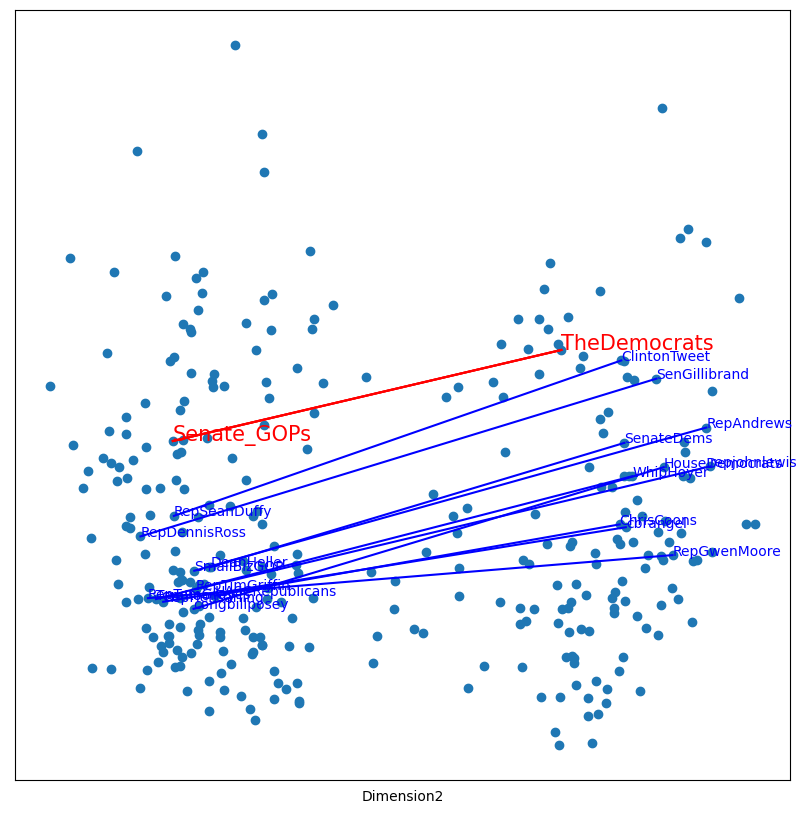

In [119]:
# final seed and augmented pair
list_10 = pairs_2_0_seed2
seed = seed_pair_2
seed_new = iterated_seed_2[-1]
list_10.append(list(seed))
vector_tar = vector_2

left = [item[0] for item in list_10]
right = [item[1] for item in list_10]

pca = PCA(n_components=2)
result = pca.fit_transform(vector_tar)

pyplot.figure(figsize=(10, 10))
pyplot.scatter(result[:, 0], result[:, 1])
words = list_celebrity
for i, word in enumerate(words):
    if word == seed[0] or word == seed[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='red', fontsize = 15)
    # elif word == seed_new[0] or word == seed_new[1]:
    #     pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='blue', fontsize = 15)
    elif (word in left) or (word in right):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='blue')
# pyplot.show()

# Add lines connecting pairs.
for pair in list_10:
    point1 = result[words.index(pair[0])]
    point2 = result[words.index(pair[1])]
    if pair == list(seed):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-')  # 'k-' means black color, straight line
    elif pair == list(seed_new):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-')  # 'k-'
    else:
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-')  # 'k-' means black color, straight line
pyplot.xticks([])
pyplot.yticks([])
pyplot.xlabel('Dimension1')
pyplot.xlabel('Dimension2')

# pyplot.savefig('/Users/lvenbo/Desktop/final_pairs_2_0.png')
pyplot.show()

In [ ]:
# final seed and augmented pair
list_10 = iterated_seed_2
seed = seed_pair_2
seed_new = iterated_seed_2[-1]
list_10.append(list(seed))
list_10.append(list(seed_new))


left = [item[0] for item in list_10]
right = [item[1] for item in list_10]

pca = PCA(n_components=2)
result = pca.fit_transform(vector_50)

pyplot.figure(figsize=(10, 10))
pyplot.scatter(result[:, 0], result[:, 1])
words = list_celebrity
for i, word in enumerate(words):
    if word == seed[0] or word == seed[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='red', fontsize = 15)
    elif word == seed_new[0] or word == seed_new[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='black', fontsize = 15)
    elif (word in left) or (word in right):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='darkorange')
# pyplot.show()
# Add lines connecting pairs.
for pair in list_10:
    point1 = result[words.index(pair[0])]
    point2 = result[words.index(pair[1])]
    if pair == list(seed):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-')  # 'k-' means black color, straight line
    elif pair == list(seed_new):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-')  # 'k-'
    else:
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'y-')  # 'k-' means black color, straight line
pyplot.xticks([])
pyplot.yticks([])
pyplot.savefig('/Users/lvenbo/Desktop/seed_pairs_2.png')
pyplot.show()

In [ ]:
list1 = [i for i in range(318)]
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(list1, list1, 'b--')
plt.scatter(rank_2_10_seed2, rank_2_20_seed2, s=5, color='r')

plt.xlabel('rank with 0 iteration')
plt.ylabel('rank with 10 iteration')
# plt.title('score comparison with different seed '+ str(num1)+','+ str(num2))

# plt.savefig('/Users/lvenbo/Desktop/fig_dim2_iter_10_30.png')

In [ ]:
list1 = [i for i in range(318)]
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(list1, list1, 'b--')
plt.scatter(rank_2_20_seed2, rank_2_30_seed2, s=5, color='r')

plt.xlabel('rank with 5 seed iteration')
plt.ylabel('rank with 10 seed iteration')
# plt.title('score comparison with different seed '+ str(num1)+','+ str(num2))

# plt.savefig('/Users/lvenbo/Desktop/fig_dim2_iter_10_30.png')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed

# Plot on the first subplot
axes[0].scatter(rank_2_10_seed2, rank_2_20_seed2, s=5, color='r')
axes[0].plot(list1, list1, 'b--')
axes[0].set_xlabel('rank with 0 seed iterations')
axes[0].set_ylabel('rank with 5 seed iterations')

axes[1].scatter(rank_2_20_seed2, rank_2_30_seed2, s=5, color='r')
axes[1].plot(list1, list1, 'b--')
axes[1].set_xlabel('rank with 5 seed iterations')
axes[1].set_ylabel('rank with 10 seed iterations')

plt.tight_layout()
plt.savefig('/Users/lvenbo/Desktop/fig_2dim_iter.png')
# Show the plots
plt.show()

dim 50 results

In [ ]:
_, rank_50_30_seed2, pairs_50_30_seed2 = different_seed_compare(seed_pair_2, 0, dimen_generator_dim50, df_pca_50)

In [ ]:
iterated_seed_10 = [['repjohnlewis', 'GOPLeader'], ['chakafattah', 'Senate_GOPs'], ['RepBarbaraLee', 'JimDeMint'], ['EleanorNorton', 'CongJoeWilson']]

In [ ]:
from scipy import stats
stats.pearsonr()

In [ ]:
# final seed and augmented pair
list_10 = pairs_50_30_seed2
seed = seed_pair_2
list_10.append(list(seed))
vector_tar = vector_50

left = [item[0] for item in list_10]
right = [item[1] for item in list_10]

pca = PCA(n_components=2)
result = pca.fit_transform(vector_tar)

pyplot.figure(figsize=(10, 10))
pyplot.scatter(result[:, 0], result[:, 1])
words = list_celebrity
for i, word in enumerate(words):
    if word == seed[0] or word == seed[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='red', fontsize = 15)
    # elif word == seed_new[0] or word == seed_new[1]:
    #     pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='blue', fontsize = 15)
    elif (word in left) or (word in right):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='blue')
# pyplot.show()

# Add lines connecting pairs.
for pair in list_10:
    point1 = result[words.index(pair[0])]
    point2 = result[words.index(pair[1])]
    if pair == list(seed):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-')  # 'k-' means black color, straight line
    elif pair == list(seed_new):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-')  # 'k-'
    else:
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-')  # 'k-' means black color, straight line
pyplot.xticks([])
pyplot.yticks([])
pyplot.savefig('/Users/lvenbo/Desktop/final_pairs_50_0.png')
pyplot.show()

In [ ]:
# final seed and augmented pair
list_10 = pairs_50_30_seed2
seed = seed_pair_2
seed_new = iterated_seed_10[-1]
list_10.append(list(seed))
list_10.append(list(seed_new))
vector_tar = vector_50

left = [item[0] for item in list_10]
right = [item[1] for item in list_10]

pca = PCA(n_components=2)
result = pca.fit_transform(vector_tar)

pyplot.figure(figsize=(10, 10))
pyplot.scatter(result[:, 0], result[:, 1])
words = list_celebrity
for i, word in enumerate(words):
    if word == seed[0] or word == seed[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='red',fontsize = 15)
    elif word == seed_new[0] or word == seed_new[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='blue', fontsize = 15)
    elif (word in left) or (word in right):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='darkorange')
# pyplot.show()

# Add lines connecting pairs.
for pair in list_10:
    point1 = result[words.index(pair[0])]
    point2 = result[words.index(pair[1])]
    if pair == list(seed):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-')  # 'k-' means black color, straight line
    elif pair == list(seed_new):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-')  # 'k-'
    else:
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'y-')  # 'k-' means black color, straight line
pyplot.xticks([])
pyplot.yticks([])
pyplot.savefig('/Users/lvenbo/Desktop/final_pairs_50.png')
pyplot.show()

In [ ]:
# final seed and augmented pair
list_10 = iterated_seed_10
seed = seed_pair_2
seed_new = iterated_seed_10[-1]
list_10.append(list(seed))
list_10.append(list(seed_new))


left = [item[0] for item in list_10]
right = [item[1] for item in list_10]

pca = PCA(n_components=2)
result = pca.fit_transform(vector_50)

pyplot.figure(figsize=(10, 10))
pyplot.scatter(result[:, 0], result[:, 1])
words = list_celebrity
for i, word in enumerate(words):
    if word == seed[0] or word == seed[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='red', fontsize = 15)
    elif word == seed_new[0] or word == seed_new[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='black', fontsize = 15)
    elif (word in left) or (word in right):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color='darkorange')
# pyplot.show()
# Add lines connecting pairs.
for pair in list_10:
    point1 = result[words.index(pair[0])]
    point2 = result[words.index(pair[1])]
    if pair == list(seed):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-')  # 'k-' means black color, straight line
    elif pair == list(seed_new):
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-')  # 'k-'
    else:
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'y-')  # 'k-' means black color, straight line
pyplot.xticks([])
pyplot.yticks([])
pyplot.savefig('/Users/lvenbo/Desktop/seed_pairs_50.png')
pyplot.show()

In [ ]:
def transform_df_re(tar_df):
    re_df = pd.DataFrame(columns=tar_df.columns)
    re_df['partisan'] = -tar_df['partisan']
    rank1 = re_df['partisan'].rank()
    re_df['rank'] = rank1
    return pd.DataFrame(re_df['rank'])